# Tutorial 5 - FOSWEC
The goal of this tutorial is to show a design problem for a bottom-hinged oscillating-surge WEC.
The WEC in this tutorial is a single, fixed-bottom flap of the floating oscillating-surge WEC (FOSWEC).

* SAND report: https://doi.org/10.2172/1717884
* Journal paper: https://doi.org/10.1016/j.energy.2021.122485
* YouTube video: https://youtu.be/OUxbaEC2K6Y

This tutorial introduces...

In [77]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import gmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## Experimental validation
During the testing campaign for the FOSWEC, a number of trials were run while providing white noise inputs to the generator at the hinge of each flap.
The base of the FOSWEC was kept fixed for these tests.
The white noise inputs and the WEC reponse allowed for the understanding of the excitation and the impedance associated with the aft and bow flaps.
To establish a reliable model, a fixed FOSWEC is modeled below and compared to the impedance from the experiment.

#### Load Impedance
First, we can load in the impedance data which has been calculated based on the white noise runs.

In [78]:
datafile = 'data/FOSWEC_empirical_data.nc'
empirical_data = xr.load_dataset(datafile)

f_vec_exp = empirical_data['omega']/(2*np.pi)
Zi_data_exp = empirical_data.Zi_data_real + 1j*empirical_data.Zi_data_imag

#### Hydrostatic stiffness
Among the experiments completed in the wave tank included gradually ramping up the torque applied by the generator to determine the relationship between torque on the flap and the resultant position.
These tests were performed without any wave conditions.
The relationship between the torque and position of the flap reveals the hydrostatic stiffness.
The experiments were performed on one flap but the hydrostatic stiffness should be the same for both because they are identical.
We do it linearly here, but nonlinearly later....

Text(0, 0.5, 'Torque (Nm)')

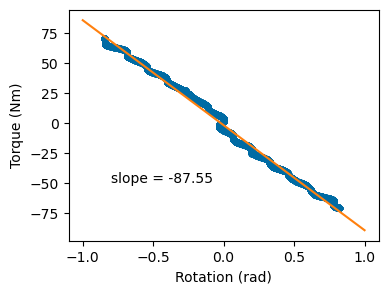

In [79]:
# load in data from ramps experiments
datafile = 'data/FOSWEC_ramps.nc'
ramps_data = xr.load_dataset(datafile)

# fit a linear curve
coefficients = np.polyfit(ramps_data['position'], ramps_data['torque'], 1)
pos_fitted = np.linspace(-1,1,100)
torque_fitted = np.polyval(coefficients, pos_fitted)

plt.figure(figsize=(4,3))
plt.plot(ramps_data['position'], ramps_data['torque'],'.')
plt.plot(pos_fitted,torque_fitted,'-')
plt.text(-0.8, -50, f'slope = {round(coefficients[0],2)}')
plt.xlabel('Rotation (rad)')
plt.ylabel('Torque (Nm)')

#### FOSWEC Geometry
The FOSWEC geometry is intended to be the same as from the experiments. 
Inputs to the function used to create the FOSWEC FloatingBody are the draft (uncertain from experiments) and hydrostatic coefficient (from ramps data above).
By testing a few values for the flap draft and comparing to the impedance data, we can determine a draft value which achieves a good match between the BEM data and empirical impedance.

In [80]:
def fixedFOSWEC(draft, hs_coeff):

    # parameters from experiments
    flap_height = 0.58 
    flap_draft = draft
    flap_freeboard = flap_height - flap_draft
    flap_width = 0.76
    flap_thickness_bottom = 0.05
    flap_thickness_top = 0.12
    hinge_location = -flap_draft - .046
    mass = 23.1
    pitch_inertia_about_cg = 1.19
    z_cg_from_bottom = 0.17
    z_cg = -flap_draft + z_cg_from_bottom
    distance_between_flaps = 1.28

    mesh_size_factor = 0.2 # appropriate mesh size to avoid frequency spikes

    # mesh 1st flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly = geom.add_polygon(
                [[-flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2, -flap_width/2, -flap_draft],
                [flap_thickness_top/2, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.extrude(flap_poly,[0,flap_width,0])
        flap_mesh = geom.generate_mesh()

    # mesh 2nd flap
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap_poly2 = geom.add_polygon(
                [[-flap_thickness_bottom/2 + distance_between_flaps, -flap_width/2, -flap_draft],
                [flap_thickness_bottom/2 + distance_between_flaps, -flap_width/2, -flap_draft],
                [flap_thickness_top/2 + distance_between_flaps, -flap_width/2, flap_freeboard],
                [-flap_thickness_top/2 + distance_between_flaps, -flap_width/2, flap_freeboard]],mesh_size=mesh_size_factor)
        geom.extrude(flap_poly2,[0,flap_width,0])
        flap_mesh2 = geom.generate_mesh()

    # add degrees of freedom for rotation around bottom hinge
    flap1_fb = cpy.FloatingBody(flap_mesh, name='flap_bow', center_of_mass=(0, 0, z_cg))
    axis1 = cpy.Axis(vector=(0, 1, 0), point=(0, 0, hinge_location))
    flap1_fb.add_rotation_dof(axis = axis1, name="pitch_bow_hinge") # used for BEM
    flap1_fb.rotation_center = (0, 0, hinge_location) # rotation center hydrostatics if not defined manually
    flap1_fb.keep_immersed_part() # keep immersed part should be run on each body separately before combining!

    flap2_fb = cpy.FloatingBody(flap_mesh2, name='flap_aft', center_of_mass=(distance_between_flaps, 0, z_cg))
    axis2 = cpy.Axis(vector=(0, 1, 0), point=(distance_between_flaps, 0, hinge_location))
    flap2_fb.add_rotation_dof(axis = axis2, name="pitch_aft_hinge")
    flap2_fb.rotation_center = (distance_between_flaps, 0, hinge_location)
    flap2_fb.keep_immersed_part() 

    foswec_fb = flap1_fb + flap2_fb
    foswec_fb.show_matplotlib()

    # use parallel axis theorem to move inertia to base
    pitch_inertia_about_base = pitch_inertia_about_cg + mass*(z_cg - hinge_location)
    rigid_inertia_matrix_xr = xr.DataArray(data=np.diag([pitch_inertia_about_base, pitch_inertia_about_base]),
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(foswec_fb.dofs),
                                        'radiating_dof': list(foswec_fb.dofs)},
                                name="inertia_matrix")
    foswec_fb.inertia_matrix = rigid_inertia_matrix_xr

    stiffness_matrix_xr = xr.DataArray(data=np.diag([np.squeeze(hs_coeff), np.squeeze(hs_coeff)]),
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof': list(foswec_fb.dofs),
                                        'radiating_dof': list(foswec_fb.dofs)},
                                name="hydrostatic_stiffness")
    foswec_fb.hydrostatic_stiffness = stiffness_matrix_xr

    return foswec_fb

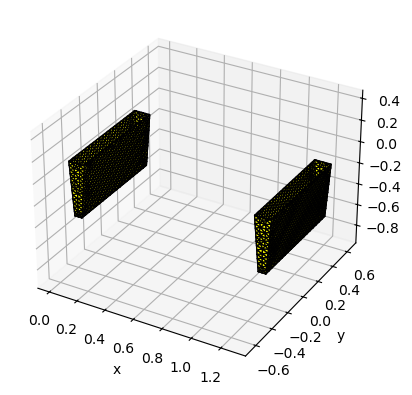

[16:50:36] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

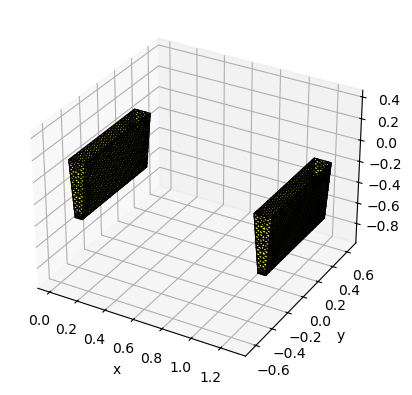

[16:54:36] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

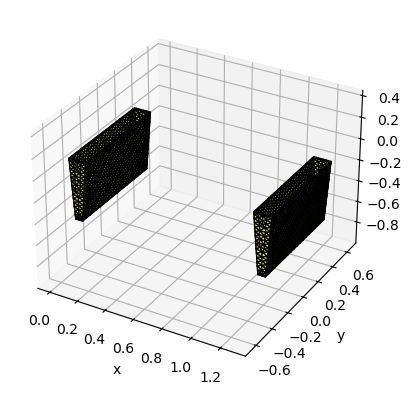

[16:59:07] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [81]:
draft_check = np.linspace(0.5, 0.56, 3)

f1 = .01
nfreq = 100
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

for draft in draft_check:
    foswec_fb = fixedFOSWEC(draft, -coefficients[0])

    filename = f'data/FOSWEC_bem_{round(draft,2)}draft.nc'
    try:
        bem_data = wot.read_netcdf(filename)
    except:
        bem_data = wot.run_bem(foswec_fb, freq)
        wot.write_netcdf(filename, bem_data)

    friction = 12*np.diag((2,2))
    hd = wot.add_linear_friction(bem_data, friction = friction) 
    #we're not actually adding friction, but need the datavariables in hd 
    hd = wot.check_radiation_damping(hd)
    intrinsic_impedance = wot.hydrodynamic_impedance(hd)
    

#### BEM solution

We can use the `FloatingBody` and frequency vector created earlier to run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object.
This is wrapped into the `wecopttool.run_bem` function.

If you would like to save the BEM data to a NetCDF file for future use, uncomment the second line of the cell below to use the `wot.write_netcdf` function.

In [ ]:
bem_data = wot.run_bem(fb, freq)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file

Next, we use the utilities class `wecopttool.utilities`, which has functions that help you analyze and design WECs, but are not needed for the core function of WecOptTool.
For example, we calculate the WEC's intrinsic impedance with its hydrodynamic coefficients and inherent inertial properties. We make use of `wecopttool.add_linear_friction()` to convert the `bem_data` into a dataset which contains all zero friction data, because `wecopttool.check_radiation_damping()` and `wecopttool.hydrodynamic_impedance()` excpect a data variable called 'friction'.

The intrinsic impedance tells us how a hydrodynamic body responds to different excitation frequencies. For oscillating systems we are intersted in both, the amplitude of the resulting velocity as well as the phase between velocity and excitation force. Bode plots are useful tool to visualize the frequency response function.

The natural frequency reveals itself as a trough in the intrinsic impedance for restoring degrees of freedom (heave, roll, pitch).

In [ ]:
hd = wot.add_linear_friction(bem_data, friction = None) 
#we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

intrinsic_impedance = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(intrinsic_impedance,
                                              'WaveBot Intrinsic Impedance')

#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC.
Data wrapped into our `PTO` class will be used to provide the additional force and constraint for our `WEC` object definition, as well as our optimization problem later.

To create an instance of the `PTO` class, we need:

* The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom.
In this case, the PTO extracts power directly from the heaving motion of the WEC, so the kinematics matrix is simply a $1 \times 1$ identity matrix.
* The definition of the PTO controller.
The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force.
However, we will be using an unstructured controller in this case, which is the default when `controller=None`.
* Any PTO impedance.
We are only interested in mechanical power for this first problem, so we will leave this empty for now.
* The non-linear power conversion loss (assumed 0% if `None`)
* The PTO system name, if desired

In [ ]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now we define the PTO forcing on the WEC and the PTO constraints.
We set the maximum PTO force as 750 Newtons.
This value is chosen somewhat arbitrary to highlight different effects throughout this tutorial.
In practice, the user would need to identify their limiting component in the PTO and then compute a suitable value.
For example, if the generator drive has a maximal current $I_{max}$ of 10 A, with a generator torque constant $K_t$ of 8 Nm/A and a gear ratio $N$ of 9 rad/m, this results in a max PTO linear force of $F = N K_{t} I_{max} = 9$ rad/m $\times 8$ Nm $\times 10$ A $= 720$ N.

We will enforce the constraint at 4 times more points than the dynamics; see [Theory]((https://sandialabs.github.io/WecOptTool/theory.html)) for why this is helpful for the pseudo-spectral problem.
The constraints must be in the correct format for `scipy.optimize.minimize`, which is the solver WecOptTool uses. See the documentation for the solver [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and note the matching syntax of `ineq_cons` below.

In [ ]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 750.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself!
Since we ran the BEM already, we can define the object using the `wecopttool.WEC.from_bem` function.
If we saved BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [ ]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

_Note: You may receive a warning regarding negative linear damping values._
_By default, WecOptTool ensures that the BEM data does not contain non-negative damping values._
_If you would like to correct the BEM solution to a different minimum damping value besides zero, you can specify_ `min_damping`.

### Objective function
The objective function is the quantity we want to optimize—in this case, the average mechanical power.
The function to compute this can be taken directly from the `PTO` object we created:

In [ ]:
obj_fun = pto.mechanical_average_power

The objective function is itself a function of the optimization state `x_opt`.
The length of `x_opt`, `nstate_opt`, needs to be properly defined to successfully call `scipy.optimize.minimize`.
In other words, it should match the quantities we are interested in optimizing.
In this case, we are optimizing for the control trajectories of an unstructured PTO, which can be represented in the Fourier domain by the DC (zero frequency) component, then the real and imaginary components for each frequency.

In [ ]:
nstate_opt = 2*nfreq

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients.
This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave).
Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero.

### Solve
We are now ready to solve the problem.
WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

The only required inputs for defining and solving the problem are:

1. The wave environment
2. The objective function
3. The size of the optimization state (`nstate_opt`)

Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance.
See the `scipy.optimize.minimize` documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for more details.

To help the problem converge faster, we will scale the problem before solving it (see the [Scaling](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) section of the Theory documentation).
WecOptTool allows you to scale the WEC dynamics state, the optimization state, and the objective function separately.
See the `wecopttool.WEC.solve` documentation [here](https://sandialabs.github.io/WecOptTool/api_docs/wecopttool.WEC.solve.html#wecopttool-wec-solve).


Pay attention to the `Exit mode`: an exit mode of `0` indicates a successful solution.
A simple problem (linear, single degree of freedom, unconstrained, etc.) should converge in well under 100 iterations.
If you exceed this, try adjusting the scales by orders of magnitude, one at a time.

In [ ]:
options = {'maxiter': 200}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

### Analyzing results
We will use two post-processing functions to obtain frequency and time domain results for the WEC and PTO responses.
The `wec.post_process` and `pto.post_process` functions both post-process the results for each wave phase realization.
The pseudo-spectral method gives continuous in time results.
To get smoother looking plots, we specify five subpoints betweeen co-location points.

In [ ]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

The `pto.post_process` function returns a list of `xarray.Dataset` objects, each element of which has built-in integration with PyPlot for smart plotting with automatic titles and formatting.
We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

In [ ]:
plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()

We could similarly plot any time or frequency domain response of the WEC or PTO by calling the specific type of response (position, velocity, force, etc.).
For example, to plot the WEC heave position and PTO force:

In [ ]:
plt.figure()
wec_tdom[0]['pos'].plot()

plt.figure()
pto_tdom[0]['force'].plot()

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`).
For example, the time domain PTO variable contains the following response:

In [ ]:
pto_tdom

Lastly, we will visualize the average power at different stages and how the power flows through the system.


In [ ]:
p_flows = wot.utilities.calculate_power_flows(wec,
                                              pto, 
                                              results, 
                                              waves, 
                                              intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows)


On the very left of the power flow Sankey diagram we start with the *Optimal Excitation*, which is only determined by the incident wave and the hydrodynamic damping and friction. 
In order for the actual *Excited* power to equal the *Optimal Excitation* the absorbed *Mechanical* power would need to equal the *Radiated* power (power that is radiated away from the WEC). In this case the *Unused Potential* would be zero.
In other words, you can never convert more than 50% of the incident wave energy into kinetic energy. For more information on this we refer to Johannes Falnes Book - Ocean Waves and Oscillating System, specifically Chapter 6.

However, the optimal 50% absorption is an overly optimistic goal considering that real world systems are likely constrained in their oscillation velocity amplitude and phase, due to limitations in stroke and applicable force.


The PTO force constraint used in this optimization also stopped us from absorbing the maximal potential wave energy. It is notable that we absorbed approximately 3/4 of the maximal absorbable power (*Mechanical* / (1/2 *Optimal Excitation*)), with relatively little *Radiated* power (about 1/2 of the absorbed power). To also absorb the last 1/4 of the potential wave power, we would need to increase the *Radiated* power three times!!


A more important question than "How to achieve optimal absorption?" is "How do we optimize usable output power?", i.e. *Electrical* power. For this optimization case we used a lossless PTO that has no impedance in itself. Therefore, the *Electrical* power equals the absorbed *Mechanical* power.
We'll show in the following sections that this a poor assumption and that the power flow looks fundamentally different when taking the PTO dynamics into account!!


## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on a different objective function: we will now optimize for <u>electrical</u> power rather than mechanical, as this is a form of power that is usable and transportable.

Since we are still dealing with the same WaveBot as in Part 1, we can reuse the BEM, WEC-PTO kinematics, and wave data from before.

<div>
<img src="https://live.staticflickr.com/65535/52435033525_b8efc28d16_k.jpg" width="1000">
</div>

The biggest difference when considering electrical power is the addition of the PTO dynamics.
In other words, we no longer assume a lossless PTO.
We will express the PTO dynamics in the form of a [2-port impedance model](https://en.wikipedia.org/wiki/Impedance_parameters) to incorporate the dynamics of the drivetrain and generator.
The additional mechanical energy storage through the drivetrain is modeled using Newton's second law, and we assume a linear generator using a power-invariant park transform.

The PTO impedance matrix components are then obtained under open-circuit conditions: no load current ($i_{pto}$ in figure above) or no WEC velocity ($vel_{pto}$ above), respectively.
See Section II of Michelén et al. [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10114969) for more details about how the code below is derived.

In [ ]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance_2 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

Next, we will create a new `PTO` object with this impedance matrix.
We will also update the definitions of our PTO constraint and additional dynamic forcing function to use the new object.
We will again set our maximum PTO force to 750 Newtons in this example, so we do not need to redefine `f_max`.

In [ ]:
## Update PTO
name_2 = ['PTO_Heave_Ex2']
pto_2 = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_2, loss, name_2)

## Update PTO constraints and forcing
def const_f_pto_2(wec, x_wec, x_opt, waves):
    f = pto_2.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())
ineq_cons_2 = {'type': 'ineq', 'fun': const_f_pto_2}
constraints_2 = [ineq_cons_2]
f_add_2 = {'PTO': pto_2.force_on_wec}

Finally, we will update our `WEC` object with the new PTO and objective function, then run our optimization problem.
Note we are now using `average_power` instead of `mechanical_average_power` as our objective function.

In [ ]:
# Update WEC
wec_2 = wot.WEC.from_bem(bem_data,
                         constraints=constraints_2,
                         friction=None,
                         f_add=f_add_2
)

# Update objective function
obj_fun_2 = pto_2.average_power

# Solve
scale_x_wec = 1e1  
scale_x_opt = 1e-3  
scale_obj = 1e-2  

results_2 = wec_2.solve(
    waves, 
    obj_fun_2, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')

# Post-process
wec_fdom_2, wec_tdom_2 = wec_2.post_process(wec_2, results_2, waves, nsubsteps)
pto_fdom_2, pto_tdom_2 = pto_2.post_process(wec_2, results_2, waves, nsubsteps)

We will compare our optimal results to the unconstrained case to gain some insight into the effect of the constraint on the optimal PTO force.
Let's do the same process as before, but unset the `constraints` parameter in a new `WEC` object.

In [ ]:
wec_2_nocon = wot.WEC.from_bem(
    bem_data,
    constraints=None,
    friction=None,
    f_add=f_add_2)

results_2_nocon = wec_2_nocon.solve(
    waves,
    obj_fun_2, 
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2_nocon[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')
wec_fdom_2_nocon, wec_tdom_2_nocon = wec_2_nocon.post_process(
    wec_2_nocon, results_2_nocon, waves, nsubsteps)
pto_fdom_2_nocon, pto_tdom_2_nocon = pto_2.post_process(
    wec_2_nocon, results_2_nocon, waves, nsubsteps)

Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of 750 Newtons.

In [ ]:
plt.figure()
wec_tdom[0]['pos'].plot(label='optimal mechanical')
wec_tdom_2[0]['pos'].plot(label='optimal electrical, constrained')
wec_tdom_2_nocon[0]['pos'].plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['force'].plot(label='optimal mechanical')
pto_tdom_2[0]['force'].plot(label='optimal electrical, constrained')
pto_tdom_2_nocon[0]['force'].plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom[0]['power'].sel(type='mech').plot(label='optimal mechanical')
pto_tdom_2[0]['power'].sel(type='elec').plot(label='optimal electrical, constrained')
pto_tdom_2_nocon[0]['power'].sel(type='elec').plot(label='optimal electrical, unconstrained')
plt.legend(loc='lower right')


The attentive user might have noticed that the amplitude of the mechanical power is less compared to Part 1 of the tutorial.
We can see that optimizing for electrical power requires optimal state trajectories with less reactive mechanical power (i.e. power that is put into the system).

The PTO force trajectory for optimizing mechanical power is saturated at the maximum for longer compared to the electrical power.
This could inform the WEC designer optimizing for mechanical power to consider larger components that would not be utilized at their limit as frequently.
However, the electrical power (_not_ the mechanical power) is the usable form of power, thus designing the WEC for optimal electrical power does not indicate a need for larger components and prevents this over-design.

The Sankey power flow diagram confirm this observation.

In [ ]:
p_flows_2 = wot.utilities.calculate_power_flows(wec_2, pto_2, results_2, waves, intrinsic_impedance)
wot.utilities.plot_power_flow(p_flows_2)

## 3. Control co-design of the WEC geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power.
In Part 3, we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design in conjunction with an optimal controller for electrical power.

Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant hull volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius.

This example demonstrates a complete case of the control co-optimization studies WecOptTool is meant for. 
The inner optimization loop finds the control trajectory that produces the optimal PTO force for a given hull geometry, and the outer optimization loop finds the optimal hull geometry _amongst designs with optimal control trajectories_.

The inner loop is consolidated into the `WEC.solve()` method, but the outer loop needs to be configured by the user for their particular design problem.
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute` (click [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html) for documentation).  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg) 
<div>
<img src="https://live.staticflickr.com/65535/52434071157_187eb4334c_k.jpg" width="1000">
</div>



### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

In [ ]:
r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem.
We use the same workflow used in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which sets `r2` and (indirectly) `h2`.

In [ ]:
def design_obj_fun(x):

    # Unpack geometry variables
    r2 = x[0]
    h2 = h2_from_r2(r2)
    print(f"\nr2 = {r2:.2f}:")

    # Set up Capytaine floating body
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = fb.nb_dofs

    # Run BEM
    f1 = 0.05
    nfreq = 50
    bem_data = wot.run_bem(fb, freq)

    # Impedance definition
    omega = bem_data.omega.values
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance_3 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # Set PTO object
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_3, efficiency, name)
    

    # Set PTO constraint and additional dynamic force
    nsubsteps = 4
    f_max = 750.0

    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq', 'fun': const_f_pto}
    constraints = [ineq_cons]

    f_add = {'PTO': pto.force_on_wec}

    # Create WEC
    wec = wot.WEC.from_bem(bem_data,
            constraints=constraints,
            friction=None, 
            f_add=f_add,
            )

    # Objective function
    obj_fun = pto.average_power
    nstate_opt = 2*nfreq
    
    # Solve
    scale_x_wec = 1e1  
    scale_x_opt = 1e-3  
    scale_obj = 1e-2  
    res = wec.solve(
        waves, 
        obj_fun, 
        nstate_opt, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj)

    return res[0].fun

### Solve
Finally, we call our wrapped function using `scipy.optimize.brute`.
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most electric power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

_(note: the cell below will take longer to run than the cells above, up to several minutes)_

In [ ]:
wot.set_loglevel("error")  # Suppress warnings

# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
opt_x0, opt_fval, x0s, fvals = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)

### Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for larger values of `r2`.

In [ ]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(x0s)]
ax.plot(x0s, fvals, 'k', zorder=0)
ax.scatter(x0s, fvals, c=colors, zorder=1)

ax.set_xlabel('Keel radius, $r_2$ [m]')
ax.set_ylabel('Average Power [W]')
ax.set_title('Design optimization results')
fig.tight_layout()

Note that in this case the difference in average power between the different keel radii is rather small.
This is because the PTO force constraint is active most of the time, therefore all considered geometries perform similarily.
If you remove the PTO constraint and re-run the co-optimization study, you will see that the impact of radius on average electrical power is significantly higher.